## Bài toán
Dữ liệu gồm 1135 văn bản phân vào 10 chủ đề khác nhau. Cần xây dựng và đánh giá các mô hình dự đoán nhãn của các văn bản trên.

## Đánh giá và tối ưu hoá mô hình 

- Lựa chọn các giá trị của các tham số bằng các thử nghiệm. 
- Với mỗi bộ tham số: 
    - Sử dụng phương pháp cross-validate chia dữ liệu và training, để đánh giá mô hình một cách tổng quát. 
- Sử dụng độ đo Accuracy để làm độ đo đánh giá chất lượng mô hình. 
- Với mỗi mô hình, tìm ra bộ tham số tốt nhất, và tiếp tục thử các mô hình khác. 
- So sánh các mô hình

## Mục lục
- Load dữ liệu từ thư mục
- Chuyển dữ liệu dạng text về ma trận (n x m) bằng TF. Chuyển nhãn các văn bản về dạng số.
- Lựa chọn tham số các mô hình SVM (kernel, C), Random Forest (criteria, N)
- So sánh 2 mô hình tốt nhất

In [29]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from tqdm import tqdm

from sklearn.datasets.base import load_files
from pyvi import ViTokenizer


from sklearn import svm
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.datasets.base import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

## Load dữ liệu từ thư mục

Cấu trúc thư mục như sau 

- data_sample/news_1135/

    - Kinh tế: 
        - bài báo 1.txt 
        - bài báo 2.txt 
    - Pháp luật
        - bài báo 3.txt 
        - bài báo 4.txt 

In [2]:
INPUT = 'data_sample/news_1135'
os.makedirs("images",exist_ok=True)  # thư mục lưu các các hình ảnh trong quá trình huấn luyện và đánh gía

In [3]:
# statistics
print('Các nhãn và số văn bản tương ứng trong dữ liệu')
print('----------------------------------------------')
n = 0
for label in os.listdir(INPUT):
    print(f'{label}: {len(os.listdir(os.path.join(INPUT, label)))}')
    n += len(os.listdir(os.path.join(INPUT, label)))

print('-------------------------')
print(f"Tổng số văn bản: {n}")

Các nhãn và số văn bản tương ứng trong dữ liệu
----------------------------------------------
Giải trí: 107
Khoa học - Công nghệ: 196
Kinh tế: 186
Pháp luật: 50
Sức khỏe: 75
Thể thao: 140
Thời sự: 138
Tin khác: 100
Đời sống - Xã hội: 91
Độc giả: 52
-------------------------
Tổng số văn bản: 1135


In [4]:
# load data
data_train = load_files(container_path=INPUT, encoding="utf-8")

print('mapping:')
for i in range(len(data_train.target_names)):
    print(f'{data_train.target_names[i]} - {i}')

print('--------------------------')
print(data_train.filenames[0:1])
# print(data_train.data[0:1])
print(data_train.target[0:1])
print(data_train.data[0:1])

print("\nTổng số  văn bản: {}" .format( len(data_train.filenames)))

mapping:
Giải trí - 0
Khoa học - Công nghệ - 1
Kinh tế - 2
Pháp luật - 3
Sức khỏe - 4
Thể thao - 5
Thời sự - 6
Tin khác - 7
Đời sống - Xã hội - 8
Độc giả - 9
--------------------------
['data_sample/news_1135/Tin khác/0218e1df21ce358b9c6485176a48f1fcaeedef67.txt']
[7]
['Dân_trí Sở GD & ĐT tỉnh Gia_Lai vừa ra văn_bản số 2258 / SGDĐT - VP , về việc chấn_chỉnh việc tiếp_thị sách và các vật_dụng khác trong các cơ_sở giáo_dục . Văn_bản chỉ_đạo , tuyệt_đối không cho phép các cá_nhân , tập_thể đến trường tiếp_thị , quảng_cáo mua_bán sách , dụng_cụ học_tập … cho giáo_viên và học_sinh trong nhà_trường . Các tổ_chức , cá_nhân trong ngành giáo_dục tuyệt_đối không được thực_hiện hoặc tham_gia giới_thiệu , quảng_bá , vận_động mua , phát_hành sách tham_khảo tới học_sinh hoặc phụ_huynh dưới hình_thức nào . Nhà_trường tuyệt_đối không được lưu_hành , sử_dụng sách có nội_dung không lành_mạnh , không phù_hợp với nội_dung chương_trình phổ_thông . Trường_hợp phát_hiện sách c

## Chuyển dữ liệu dạng text về ma trận (n x m) bằng TF. Chuyển nhãn các văn bản về dạng số

In [5]:
# load dữ liệu các stopwords 
with open("vietnamese-stopwords.txt") as f:
    stopwords = f.readlines()
stopwords = [x.strip().replace(" ", "_") for x in stopwords] 
print(f"Số lượng stopwords: {len(stopwords)}")
print(stopwords[:10])

# Chuyển hoá dữ liệu text về dạng vector TF 
#     - loại bỏ từ dừng
#     - sinh từ điển
module_count_vector = CountVectorizer(stop_words=stopwords)
model_rf_preprocess = Pipeline([('vect', module_count_vector),
                    ('tf', TfidfTransformer()),
                    ])
# Hàm thực hiện chuyển đổi dữ liệu text thành dữ liệu số dạng ma trận 
# Input: Dữ liệu 2 chiều dạng numpy.array, mảng nhãn id dạng numpy.array 
data_preprocessed = model_rf_preprocess.fit_transform(data_train.data, data_train.target)

print(f"\nSố lượng từ trong từ điển: {len(module_count_vector.vocabulary_)}")
print(f"Kích thước dữ liệu sau khi xử lý: {data_preprocessed.shape}")
print(f"Kích thước nhãn tương ứng: {data_train.target.shape}")

Số lượng stopwords: 2063
['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']

Số lượng từ trong từ điển: 24389
Kích thước dữ liệu sau khi xử lý: (1135, 24389)
Kích thước nhãn tương ứng: (1135,)


## Chia dữ liệu thành tập train và test

In [20]:
p = 0.2
pivot = int(data_preprocessed.shape[0] * (1-0.2))
X_train, X_test = data_preprocessed[0:pivot], data_preprocessed[pivot:]
Y_train, Y_test = data_train.target[0:pivot], data_train.target[pivot:]

 Lựa chọn tham số các mô hình SVM (kernel, C), Random Forest (criteria, N)

- Viết hàm thực hiện huấn luyện mô hình và đánh giá
- Sử dụng các thư viện hỗ trợ để vẽ đồ thị toàn bộ quá trình huấn luyện

In [21]:
def cross_validation(estimator):
    _, train_scores, test_scores = learning_curve(estimator, X_train, Y_train, cv=10, n_jobs=-1, train_sizes=[1.0, ], scoring="accuracy")
    test_scores = test_scores[0]
    mean, std = test_scores.mean(), test_scores.std()
    return mean, std

def plot(title, xlabel, X, Y, error, ylabel = "Accuracy"):
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.ylabel(ylabel)
    
    plt.errorbar(X, Y, error, linestyle='None', marker='o')

### Đánh giá hiệu quả của các kernel trong mô hình SVM

100%|██████████| 4/4 [00:26<00:00,  6.57s/it]


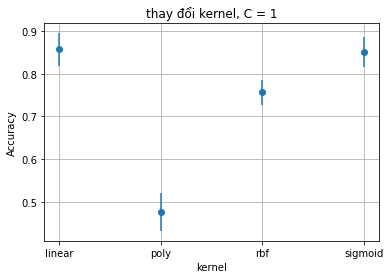

In [22]:
title = "thay đổi kernel, C = 1"
xlabel = "kernel"
X = []
Y = []
error = []

for kernel in tqdm(['linear', 'poly', 'rbf', 'sigmoid']):
    # Với mỗi kernel được chọn, 
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = svm.SVC(kernel=kernel, C=1.0)
    mean, std = cross_validation(text_clf)
    X.append(kernel)
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh 
plot(title, xlabel, X, Y, error)
plt.savefig('images/svm_change_kernel.png', bbox_inches='tight')
plt.show()


### Đánh giá ảnh hưởng của tham số C trong mô hình SVM

100%|██████████| 5/5 [00:37<00:00,  7.49s/it]


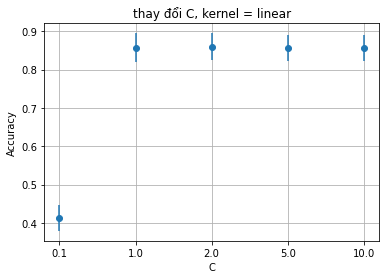

In [23]:
title = "thay đổi C, kernel = linear"
xlabel = "C"
X = []
Y = []
error = []

for C in tqdm([.1, 1.0, 2.0, 5.0, 10.0]):
    # Với từng giá trị C nhận được, 
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = svm.SVC(kernel='linear', C=C)
    mean, std = cross_validation(text_clf)
    X.append(str(C))
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('images/svm_change_C.png', bbox_inches='tight')
plt.show()


### Đánh giá ảnh hưởng độ đo trong mô hình Random Forest

100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


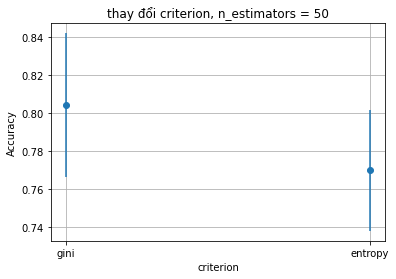

In [24]:
title = "thay đổi criterion, n_estimators = 50"
xlabel = "criterion"
X = []
Y = []
error = []

for criterion in tqdm(["gini", "entropy"]):
    # Với mỗi criterion nhận được,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = RandomForestClassifier(criterion=criterion, n_estimators=50)
    mean, std = cross_validation(text_clf)
    X.append(str(criterion))
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('images/RF_change_criterion.png', bbox_inches='tight')
plt.show()


### Đánh giá ảnh hưởng số cây trong mô hình Random Forest 

100%|██████████| 4/4 [00:16<00:00,  4.03s/it]


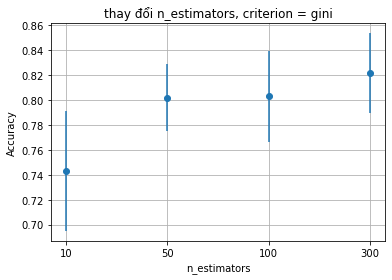

In [25]:
title = "thay đổi n_estimators, criterion = gini"
xlabel = "n_estimators"
X = []
Y = []
error = []

for n_estimators in tqdm([10, 50, 100, 300]):
    # Với từng giá trị n_estimators nhận được,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = RandomForestClassifier(criterion='gini', n_estimators=n_estimators)
    mean, std = cross_validation(text_clf)
    X.append(str(n_estimators))
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('images/RF_change_N.png', bbox_inches='tight')
plt.show()


## So sánh các mô hình với các bộ tham số tốt nhất  

In [30]:
svm_ = svm.SVC(kernel='linear', C=1.0)
rf = RandomForestClassifier(criterion='gini', n_estimators=100)

# Huấn luyện các mô hình trên tập dữ liệu train đầy đủ
svm_.fit(X_train, Y_train)
rf.fit(X_train, Y_train)

RandomForestClassifier()

In [36]:
# Kết quả dự đoán trên tập test
print(f'SVM: {svm_.score(X_test, Y_test)}')
print(f'Random Forest: {rf.score(X_test, Y_test)}')

SVM: 0.8590308370044053
Random Forest: 0.8105726872246696
